## Final summary

In [58]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyspark.sql import SparkSession, functions as F
import lbl2vec
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import numpy as np
import folium
import matplotlib
from pyspark.sql.functions import date_format
from pyspark.sql import SparkSession, functions as F
import seaborn as sns

# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("MAST30034 Project 1 part 1")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZon", "Etc/UTC")
    .config("spark.driver.memory", "4g")
    .config("spark.executor.memory", "8g")
    .getOrCreate()
)

22/10/09 14:06:44 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


### ETL

- The following ETL script downloads the external SA2 datasets and the covid 
data using URLs and then cleans and preprocesses them.
- Next, the script cleans and preprocesses the internal dataset and then merges
it with the external dataset.
- The script prepares a final dataset which is further used throughout the 
analysis to build a ranking model for the merchants.

In [59]:
%run "../scripts/ETL.py" '../scripts/paths.json'

22/10/09 14:06:44 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


### Outlier Analysis

The following dataset is the full internal + external dataset merged together. 

In [60]:
# Show the first five rows of the complete dataset
final_join3.limit(5)

merchant_name,merchant_abn,categories,take_rate,revenue_levels,name,address,state,gender,trans_merchant_abn,dollar_value,order_id,order_datetime,user_id,consumer_id,suburb,postcodes,long,lat,int_sa2,SA2_code,SA2_name,income_2018-2019,total_males,total_females,total_persons,state_code,state_name,population_2020,population_2021,fraud_probability_consumer,fraud_probability_merchant
Egestas Nunc Asso...,11121775571,digital goods: bo...,6.58,a,Christopher Rodri...,30554 Evans Strea...,NSW,Male,11121775571,11.28829564583802,2bd2a61d-72e5-42d...,2021-08-20,3698,1175,JESMOND,2299,151.704581,-32.909816,111031231,111031231,Shortland - Jesmond,242936885,6412,6179,12593,1,New South Wales,12598,12694,0.01,0.01
Morbi Accumsan In...,19618998054,tent and aWning s...,1.52,c,Christopher Rodri...,30554 Evans Strea...,NSW,Male,19618998054,62.90176609196828,3582b1f8-4577-403...,2021-05-16,3698,1175,JESMOND,2299,151.704581,-32.909816,111031231,111031231,Shortland - Jesmond,242936885,6412,6179,12593,1,New South Wales,12598,12694,0.01,0.01
Eu Dolor Egestas PC,94472466107,"cable, satellite,...",6.23,a,Christopher Rodri...,30554 Evans Strea...,NSW,Male,94472466107,172.15375126873164,cb05d49f-c2fa-453...,2021-07-22,3698,1175,JESMOND,2299,151.704581,-32.909816,111031231,111031231,Shortland - Jesmond,242936885,6412,6179,12593,1,New South Wales,12598,12694,0.01,0.01
Urna Justo Indust...,31472801314,music shops - mus...,6.56,a,Christopher Rodri...,30554 Evans Strea...,NSW,Male,31472801314,0.4894787650356477,aeec15c1-67e8-4cb...,2021-05-18,3698,1175,JESMOND,2299,151.704581,-32.909816,111031231,111031231,Shortland - Jesmond,242936885,6412,6179,12593,1,New South Wales,12598,12694,0.01,0.01
Eu Sem Pellentesq...,35424691626,"computers, comput...",3.9,b,Christopher Rodri...,30554 Evans Strea...,NSW,Male,35424691626,7.360217018778133,9df473ba-102d-461...,2021-07-04,3698,1175,JESMOND,2299,151.704581,-32.909816,111031231,111031231,Shortland - Jesmond,242936885,6412,6179,12593,1,New South Wales,12598,12694,0.01,0.01


- The outlier script removes the outliers from the above complete dataset in the 
following ways:
    - Removes values with null merchant abn
    - Removes instances with transactions with a dollar value of 0 or less 
    0
    - Removes values with null customer id
    - Remove instances where gender is null

In [61]:

%run "../scripts/outlier.py" '../scripts/paths.json'

22/10/09 14:08:03 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [62]:
df.head()

,Outlier removal,Count after outlier removal
0,Original count,10540321
1,Valid Merchant ABN,10109371
2,Transactions with non $0,10109371
3,Valid customer ID,10109371
4,Non null values for gender,10109371


As seen above, null values were only present in the merchant abn column which
were removed to prepare the final dataset

### Tags to categories


In [63]:
%run "../scripts/NLP.py" '../scripts/paths.json'

22/10/09 14:08:56 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.
THE TOP 15 WORDS FOR TOPIC #FURNITURE
['new', 'motor', 'stock', 'nursery', 'flowers', 'florists', 'home', 'furnishings', 'appliances', 'manufacturers', 'shoe', 'furniture', 'equipment', 'supplies', 'shops']


THE TOP 15 WORDS FOR TOPIC #TOYS AND DIY
['galleries', 'dealers', 'art', 'telecom', 'service', 'bicycle', 'repair', 'sales', 'artist', 'craft', 'supply', 'watch', 'clock', 'jewelry', 'shops']


THE TOP 15 WORDS FOR TOPIC #BEAUTY, HEALTH, PERSONAL AND HOUSEHOLD
['nurseries', 'books', 'periodicals', 'newspapers', 'beauty', 'health', 'spas', 'data', 'design', 'systems', 'processing', 'integrated', 'programming', 'computer', 'services']


THE TOP 15 WORDS FOR TOPIC #BOOKS, STATIONARY AND MUSIC
['printing', 'stationery', 'writing', 'instruments', 'pianos', 'musical', 'sheet', 'tent', 'awning', 'digital', 'movies', 'books', 'shops', 'goods', 'music']


THE TOP 15 WORDS

In [64]:
merchants_df.head(5)

,name,tags,merchant_abn,cleaned_tags,store_type,category
0,Felis Limited,"((furniture, home furnishings and equipment sh...",10023283211,furniture home furnishings and equipment shops...,0,Furniture
1,Arcu Ac Orci Corporation,"([cable, satellite, and otHer pay television a...",10142254217,cable satellite and other pay television and r...,4,Electronics
2,Nunc Sed Company,"([jewelry, watch, clock, and silverware shops]...",10165489824,jewelry watch clock and silverware shops,1,Toys and DIY
3,Ultricies Dignissim Lacus Foundation,"([wAtch, clock, and jewelry repair shops], [b]...",10187291046,watch clock and jewelry repair shops,1,Toys and DIY
4,Enim Condimentum PC,"([music shops - musical instruments, pianos, a...",10192359162,music shops musical instruments pianos and sh...,3,"Books, Stationary and Music"


### Visualize internal data

22/10/09 14:09:00 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


22/10/09 14:12:14 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/09 14:12:14 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/09 14:12:14 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/10/09 14:12:20 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/09 14:12:20 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/09 14:12:20 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/09 14:12:20 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/09 14:12:20 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/10/09 14:12:20 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/09 14:12:21 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/09 14:12:21 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/09 14:12:21 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/09 14:12:21 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/09 14:12:21 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/09 14:12:21 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/09 14:12:21 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/09 14:12:21 WARN RowBasedKeyValueBatch: Calling spill() on

22/10/09 14:12:24 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/09 14:12:24 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/09 14:12:24 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/10/09 14:12:24 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/09 14:12:24 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/10/09 14:12:43 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/09 14:12:43 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/09 14:12:43 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/10/09 14:12:43 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/09 14:12:43 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/09 14:12:43 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/09 14:12:43 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/09 14:12:43 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/09 14:12:43 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/09 14:12:43 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/09 14:12:43 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/09 14:12:43 WARN RowBasedKeyValueBatch: Calling spill() on

22/10/09 14:12:47 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/09 14:12:47 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/09 14:12:47 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/09 14:12:47 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/09 14:12:47 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/10/09 14:13:27 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/09 14:13:27 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/09 14:13:27 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/09 14:13:28 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/09 14:13:28 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/10/09 14:13:28 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/09 14:13:28 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/09 14:13:28 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/09 14:13:28 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/09 14:13:28 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/09 14:13:28 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/09 14:13:28 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/09 14:13:28 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/09 14:13:28 WARN RowBasedKeyValueBatch: Calling spill() on

22/10/09 14:13:31 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/09 14:13:31 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/09 14:13:31 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/09 14:13:31 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/09 14:13:31 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/10/09 14:13:31 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/09 14:13:32 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


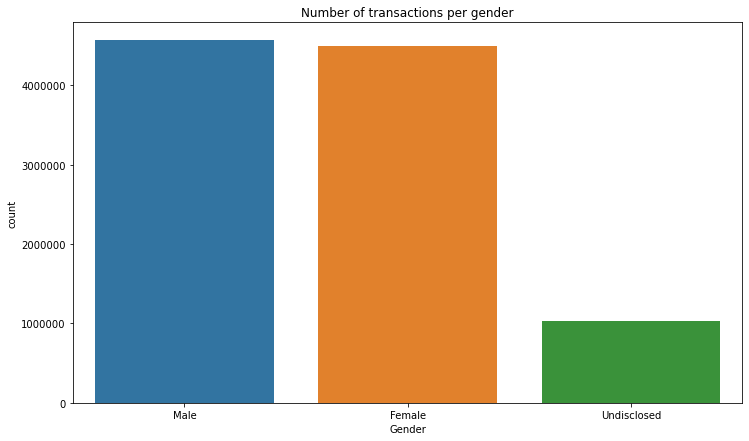

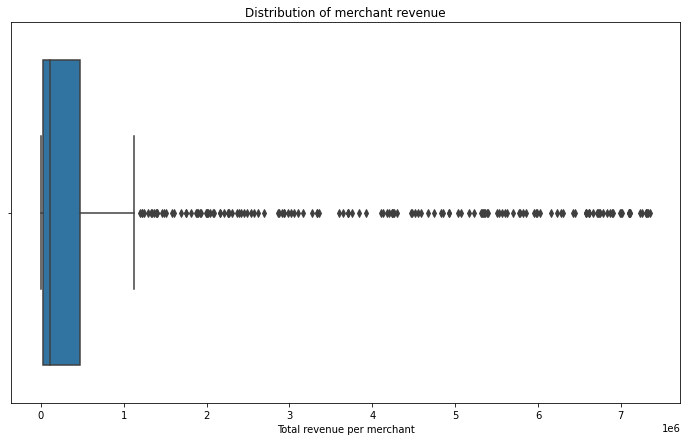

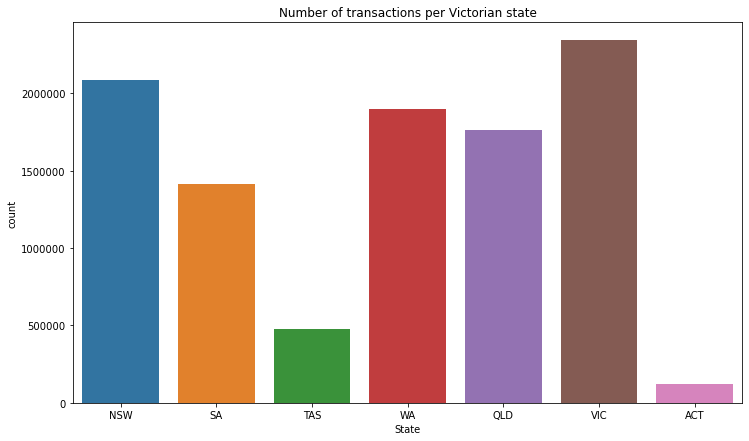

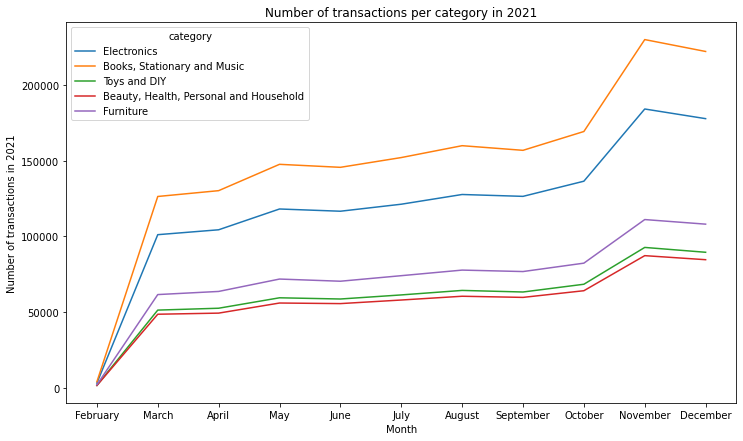

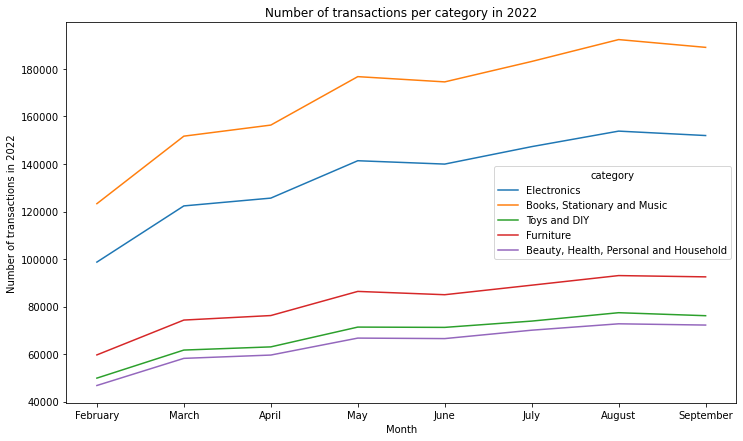

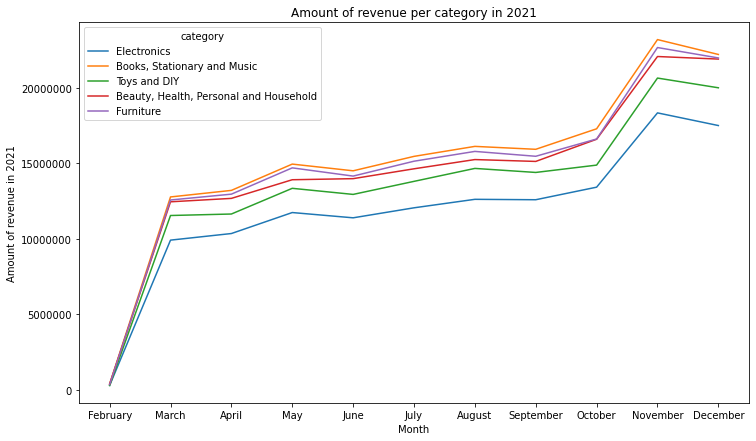

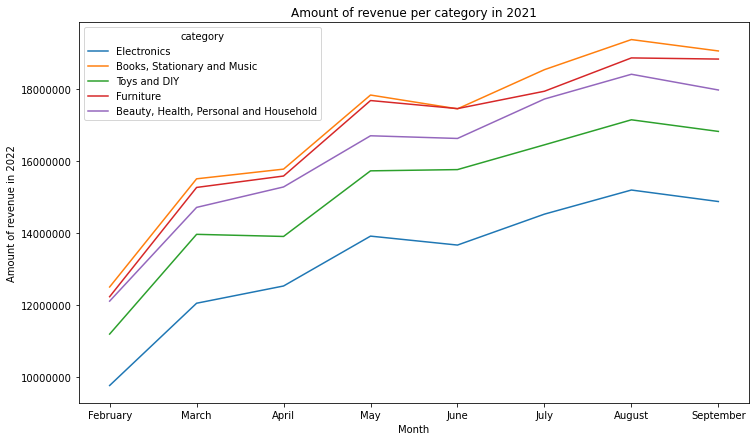

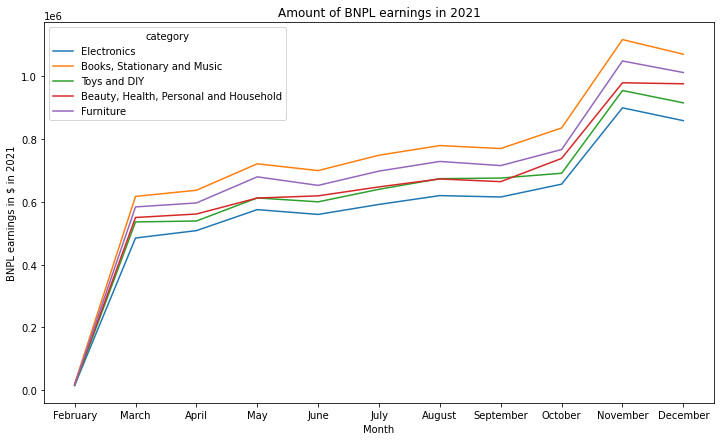

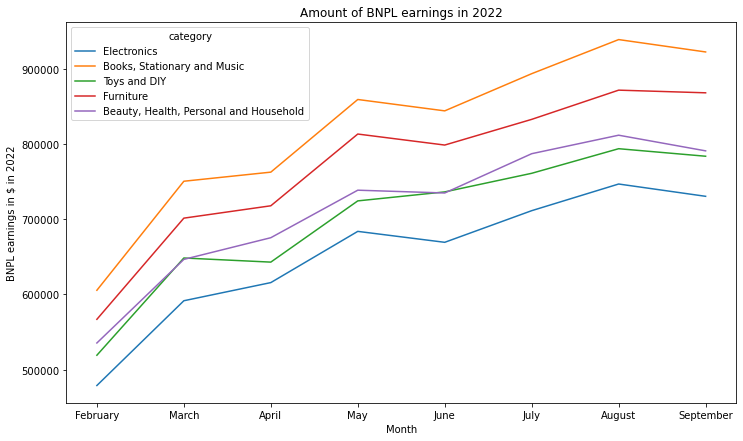

In [65]:
%run "../scripts/visualizations-1.py" '../scripts/paths.json'

### Visualizaing the fraud data

22/10/09 14:14:13 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


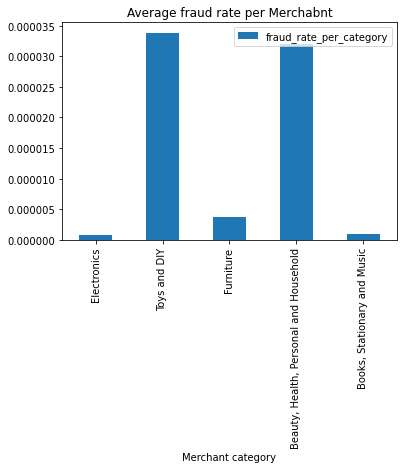

In [66]:
%run "../scripts/Fraud_viz.py" '../scripts/paths.json'

### External datasets - Outliers

22/10/09 14:14:14 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.
Summary statistics for the Census data - 


           SA2_code   total_males  total_females  total_persons
count  2.472000e+03   2472.000000    2472.000000    2472.000000
mean   3.177555e+08   5074.887136    5209.415049   10284.254450
std    1.977886e+08   3019.275754    3161.883118    6171.395057
min    1.010210e+08      0.000000       0.000000       0.000000
25%    1.270315e+08   2669.750000    2678.000000    5384.750000
50%    3.030411e+08   4774.000000    4875.000000    9656.000000
75%    4.060111e+08   7169.000000    7511.500000   14675.000000
max    9.999995e+08  14327.000000   13783.000000   28116.000000


Summary statistics for the Income data - 


    SA2_code           SA2_name  income_2018-2019
0  101021007          Braidwood         120763285
1  101021008            Karabar         338308979
2  101021009         Queanbeyan         441160946
3  101021010  

[]


Summary statistics for the Population data - 


    SA2_code                         SA2_name  state_code       state_name  \
0  101021007                        Braidwood           1  New South Wales   
1  101021008                          Karabar           1  New South Wales   
2  101021009                       Queanbeyan           1  New South Wales   
3  101021010                Queanbeyan - East           1  New South Wales   
4  101021012  Queanbeyan West - Jerrabomberra           1  New South Wales   

   population_2020  population_2021  
0             4273             4330  
1             8519             8546  
2            11437            11370  
3             5077             5093  
4            12796            12743  


Summary statistics for the population in 2020 per SA2 code data - 


count     2454.000000
mean     10454.477995
std       6229.349880
min          0.000000
25%       5449.500000
50%       9778.000000
75%      14832.750000
max      28250.000000
Nam

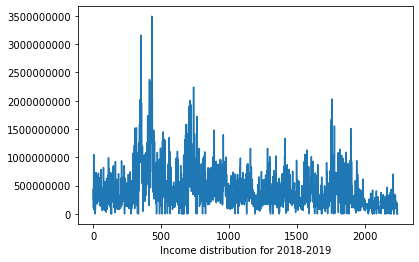

In [67]:
%run "../scripts/outlier_external.py" '../scripts/paths.json'

### Checking the impact of Covid-19 on the number of transactions

22/10/09 14:44:50 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


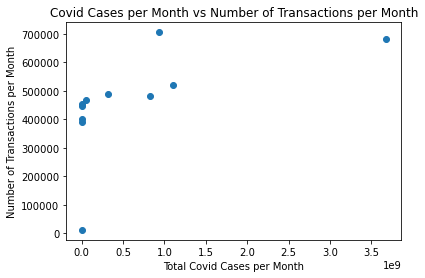

<Figure size 432x288 with 0 Axes>

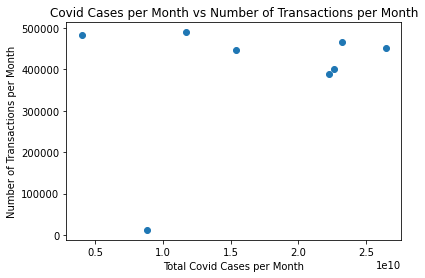

In [80]:
%run "../scripts/covid_viz.py" '../scripts/paths.json'

### Ranking models 

In [69]:
%run "../scripts/BNPL_earning_model.py" '../scripts/paths.json'

22/10/09 14:14:23 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


22/10/09 14:14:52 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/09 14:14:52 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/10/09 14:14:52 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/09 14:14:52 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/10/09 14:15:28 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/09 14:15:28 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/10/09 14:15:30 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/09 14:15:30 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/09 14:15:30 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/10/09 14:16:10 WARN DAGScheduler: Broadcasting large task binary with size 1013.6 KiB


22/10/09 14:16:11 WARN DAGScheduler: Broadcasting large task binary with size 1013.7 KiB


22/10/09 14:16:12 WARN DAGScheduler: Broadcasting large task binary with size 1017.6 KiB


22/10/09 14:16:14 WARN DAGScheduler: Broadcasting large task binary with size 1130.0 KiB


22/10/09 14:16:19 WARN MemoryStore: Not enough space to cache rdd_9675_7 in memory! (computed 188.8 MiB so far)
22/10/09 14:16:19 WARN MemoryStore: Not enough space to cache rdd_9675_5 in memory! (computed 188.8 MiB so far)
22/10/09 14:16:19 WARN MemoryStore: Not enough space to cache rdd_9675_4 in memory! (computed 83.2 MiB so far)
22/10/09 14:16:19 WARN BlockManager: Persisting block rdd_9675_7 to disk instead.
22/10/09 14:16:19 WARN MemoryStore: Not enough space to cache rdd_9675_2 in memory! (computed 188.8 MiB so far)
22/10/09 14:16:26 WARN BlockManager: Persisting block rdd_9675_2 to disk instead.
22/10/09 14:16:26 WARN BlockManager: Persisting block rdd_9675_5 to disk instead.
22/10/09 14:16:26 WARN BlockManager: Persisting block rdd_9675_4 to disk instead.


22/10/09 14:16:30 WARN DAGScheduler: Broadcasting large task binary with size 1191.6 KiB


22/10/09 14:16:33 WARN DAGScheduler: Broadcasting large task binary with size 1312.7 KiB


22/10/09 14:16:37 WARN DAGScheduler: Broadcasting large task binary with size 1554.7 KiB


22/10/09 14:16:40 WARN DAGScheduler: Broadcasting large task binary with size 2016.1 KiB


22/10/09 14:17:26 WARN DAGScheduler: Broadcasting large task binary with size 1018.9 KiB


22/10/09 14:17:28 WARN DAGScheduler: Broadcasting large task binary with size 1020.0 KiB


22/10/09 14:18:08 WARN DAGScheduler: Broadcasting large task binary with size 1018.9 KiB


22/10/09 14:18:09 WARN DAGScheduler: Broadcasting large task binary with size 1020.0 KiB


In [70]:
# Run all the models to get the features for the ranking model
%run "../scripts/Revenue_model.py" '../scripts/paths.json'

22/10/09 14:18:59 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


22/10/09 14:20:32 WARN DAGScheduler: Broadcasting large task binary with size 1015.0 KiB


22/10/09 14:20:33 WARN DAGScheduler: Broadcasting large task binary with size 1015.1 KiB


22/10/09 14:20:34 WARN DAGScheduler: Broadcasting large task binary with size 1019.0 KiB


22/10/09 14:20:36 WARN DAGScheduler: Broadcasting large task binary with size 1131.3 KiB


22/10/09 14:20:38 WARN MemoryStore: Not enough space to cache rdd_10444_1 in memory! (computed 188.8 MiB so far)
22/10/09 14:20:38 WARN BlockManager: Persisting block rdd_10444_1 to disk instead.
22/10/09 14:20:38 WARN MemoryStore: Not enough space to cache rdd_10444_3 in memory! (computed 188.8 MiB so far)
22/10/09 14:20:38 WARN BlockManager: Persisting block rdd_10444_3 to disk instead.
22/10/09 14:20:38 WARN MemoryStore: Not enough space to cache rdd_10444_7 in memory! (computed 188.8 MiB so far)
22/10/09 14:20:38 WARN BlockManager: Persisting block rdd_10444_7 to disk instead.
22/10/09 14:20:38 WARN MemoryStore: Not enough space to cache rdd_10444_2 in memory! (computed 188.8 MiB so far)
22/10/09 14:20:38 WARN BlockManager: Persisting block rdd_10444_2 to disk instead.
22/10/09 14:20:38 WARN MemoryStore: Not enough space to cache rdd_10444_6 in memory! (computed 188.8 MiB so far)
22/10/09 14:20:38 WARN BlockManager: Persisting block rdd_10444_6 to disk instead.
22/10/09 14:20:38 WA

22/10/09 14:20:42 WARN DAGScheduler: Broadcasting large task binary with size 1192.9 KiB


22/10/09 14:20:46 WARN DAGScheduler: Broadcasting large task binary with size 1314.1 KiB


22/10/09 14:20:49 WARN DAGScheduler: Broadcasting large task binary with size 1556.0 KiB


22/10/09 14:20:53 WARN DAGScheduler: Broadcasting large task binary with size 2017.9 KiB


22/10/09 14:21:35 WARN DAGScheduler: Broadcasting large task binary with size 1020.3 KiB


22/10/09 14:21:37 WARN DAGScheduler: Broadcasting large task binary with size 1021.4 KiB


22/10/09 14:22:20 WARN DAGScheduler: Broadcasting large task binary with size 1020.3 KiB


22/10/09 14:22:21 WARN DAGScheduler: Broadcasting large task binary with size 1021.4 KiB


In [71]:
%run "../scripts/Customers_model.py" '../scripts/paths.json'

22/10/09 14:23:17 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


22/10/09 14:25:06 WARN DAGScheduler: Broadcasting large task binary with size 1026.6 KiB


22/10/09 14:25:07 WARN DAGScheduler: Broadcasting large task binary with size 1026.7 KiB


22/10/09 14:25:08 WARN DAGScheduler: Broadcasting large task binary with size 1030.7 KiB


22/10/09 14:25:10 WARN DAGScheduler: Broadcasting large task binary with size 1143.0 KiB


22/10/09 14:25:12 WARN MemoryStore: Not enough space to cache rdd_11222_4 in memory! (computed 188.8 MiB so far)
22/10/09 14:25:12 WARN BlockManager: Persisting block rdd_11222_4 to disk instead.
22/10/09 14:25:12 WARN MemoryStore: Not enough space to cache rdd_11222_2 in memory! (computed 188.8 MiB so far)
22/10/09 14:25:12 WARN BlockManager: Persisting block rdd_11222_2 to disk instead.
22/10/09 14:25:12 WARN MemoryStore: Not enough space to cache rdd_11222_6 in memory! (computed 188.8 MiB so far)
22/10/09 14:25:12 WARN BlockManager: Persisting block rdd_11222_6 to disk instead.
22/10/09 14:25:12 WARN MemoryStore: Not enough space to cache rdd_11222_5 in memory! (computed 188.8 MiB so far)
22/10/09 14:25:12 WARN BlockManager: Persisting block rdd_11222_5 to disk instead.
22/10/09 14:25:12 WARN MemoryStore: Not enough space to cache rdd_11222_3 in memory! (computed 188.8 MiB so far)
22/10/09 14:25:12 WARN BlockManager: Persisting block rdd_11222_3 to disk instead.
22/10/09 14:25:12 WA

22/10/09 14:25:18 WARN DAGScheduler: Broadcasting large task binary with size 1204.4 KiB
22/10/09 14:25:19 WARN MemoryStore: Not enough space to cache rdd_11222_4 in memory! (computed 188.8 MiB so far)


22/10/09 14:25:21 WARN DAGScheduler: Broadcasting large task binary with size 1325.2 KiB


22/10/09 14:25:25 WARN DAGScheduler: Broadcasting large task binary with size 1567.0 KiB


22/10/09 14:25:29 WARN DAGScheduler: Broadcasting large task binary with size 2036.7 KiB


22/10/09 14:26:18 WARN DAGScheduler: Broadcasting large task binary with size 1031.8 KiB


22/10/09 14:26:20 WARN DAGScheduler: Broadcasting large task binary with size 1032.9 KiB


22/10/09 14:27:01 WARN DAGScheduler: Broadcasting large task binary with size 1031.8 KiB


22/10/09 14:27:02 WARN DAGScheduler: Broadcasting large task binary with size 1033.0 KiB


In [72]:
%run "../scripts/Transactions_model.py" 

22/10/09 14:29:36 WARN DAGScheduler: Broadcasting large task binary with size 1014.1 KiB


22/10/09 14:29:37 WARN DAGScheduler: Broadcasting large task binary with size 1014.1 KiB


22/10/09 14:29:39 WARN DAGScheduler: Broadcasting large task binary with size 1018.1 KiB


22/10/09 14:29:40 WARN DAGScheduler: Broadcasting large task binary with size 1130.4 KiB


22/10/09 14:29:42 WARN MemoryStore: Not enough space to cache rdd_12009_5 in memory! (computed 188.8 MiB so far)
22/10/09 14:29:42 WARN BlockManager: Persisting block rdd_12009_5 to disk instead.
22/10/09 14:29:43 WARN MemoryStore: Not enough space to cache rdd_12009_1 in memory! (computed 188.8 MiB so far)
22/10/09 14:29:43 WARN MemoryStore: Not enough space to cache rdd_12009_4 in memory! (computed 188.8 MiB so far)
22/10/09 14:29:43 WARN MemoryStore: Not enough space to cache rdd_12009_0 in memory! (computed 188.8 MiB so far)
22/10/09 14:29:43 WARN MemoryStore: Not enough space to cache rdd_12009_3 in memory! (computed 188.8 MiB so far)
22/10/09 14:29:43 WARN MemoryStore: Not enough space to cache rdd_12009_6 in memory! (computed 188.8 MiB so far)
22/10/09 14:29:43 WARN BlockManager: Persisting block rdd_12009_3 to disk instead.
22/10/09 14:29:43 WARN BlockManager: Persisting block rdd_12009_6 to disk instead.
22/10/09 14:29:43 WARN BlockManager: Persisting block rdd_12009_4 to disk

22/10/09 14:29:48 WARN DAGScheduler: Broadcasting large task binary with size 1191.8 KiB
22/10/09 14:29:49 WARN MemoryStore: Not enough space to cache rdd_12009_1 in memory! (computed 188.8 MiB so far)


22/10/09 14:29:52 WARN DAGScheduler: Broadcasting large task binary with size 1312.7 KiB


22/10/09 14:29:56 WARN DAGScheduler: Broadcasting large task binary with size 1554.5 KiB


22/10/09 14:30:00 WARN DAGScheduler: Broadcasting large task binary with size 2016.1 KiB


22/10/09 14:30:40 WARN DAGScheduler: Broadcasting large task binary with size 1019.3 KiB


22/10/09 14:30:42 WARN DAGScheduler: Broadcasting large task binary with size 1020.4 KiB


22/10/09 14:31:16 WARN DAGScheduler: Broadcasting large task binary with size 1019.3 KiB


22/10/09 14:31:17 WARN DAGScheduler: Broadcasting large task binary with size 1020.4 KiB


In [73]:
%run "../scripts/fraud_feature.py" '../scripts/paths.json'

22/10/09 14:32:10 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


### Evaluating the models

#### Extracting the top 5 important features for each model

In [74]:
%run "../scripts/model_evaluation.py" '../scripts/paths.json'

In [75]:
metrics_df

,Model name,Mean Absolute Error,RMSE
0,Predicted BNPL earnings,10.043345,16.615221
1,Predicted no. of Customers,2.106462,2.946322
2,Predicted Merchant Revenue,205.152330,338.138656
3,Predicted no. of Transactions,2.669105,3.887943


In [76]:
feature_df

,Model name,First Feature,Second Feature,Third Feature
0,Predicted BNPL earnings,BNPL_earnings,no_of_transactions,take_rate
1,Predicted no. of Customers,no_of_customers,total_earnings,income_per_person
2,Predicted Merchant Revenue,total_earnings,no_of_transactions,"category_vec_Beauty, Health, Personal and Hous..."
3,Predicted no. of Transactions,no_of_transactions,total_earnings,income_per_person


### Making the ranking model

In [77]:
# take list of values as weights for fraud, transactions, revenue, customer, BNPL earnings
%run '../scripts/ranking_model.py'  2,3,5,4,1

Ranking for  Furniture category: 
Number of merchants in this category:  261
Rank  1 :  Erat Vitae LLP
Rank  2 :  Lorem Ipsum Sodales Industries
Rank  3 :  Interdum Feugiat Sed Inc.
Rank  4 :  Phasellus At Limited
Rank  5 :  Eget Laoreet Posuere PC
Rank  6 :  Libero Et Limited
Rank  7 :  Purus Gravida Sagittis Ltd
Rank  8 :  Auctor Company
Rank  9 :  Blandit At LLC
Rank  10 :  Ornare Limited


Ranking for  Electronics category: 
Number of merchants in this category:  317
Rank  1 :  Lacus Consulting
Rank  2 :  Ipsum Dolor Sit Corporation
Rank  3 :  Placerat Eget Venenatis Limited
Rank  4 :  Mauris Non Institute
Rank  5 :  Phasellus At Company
Rank  6 :  Dictum Phasellus In Institute
Rank  7 :  Ultricies Dignissim LLP
Rank  8 :  Orci In Consequat Corporation
Rank  9 :  Ornare Fusce Inc.
Rank  10 :  Faucibus Leo Ltd


Ranking for  Toys and DIY category: 
Number of merchants in this category:  196
Rank  1 :  Leo In Consulting
Rank  2 :  Vehicula Pellentesque Corporation
Rank  3 :  Gravida 

### Insights 

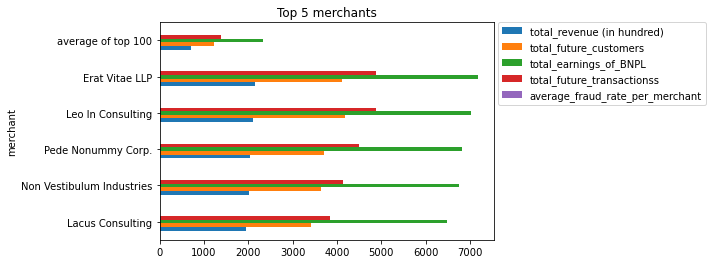

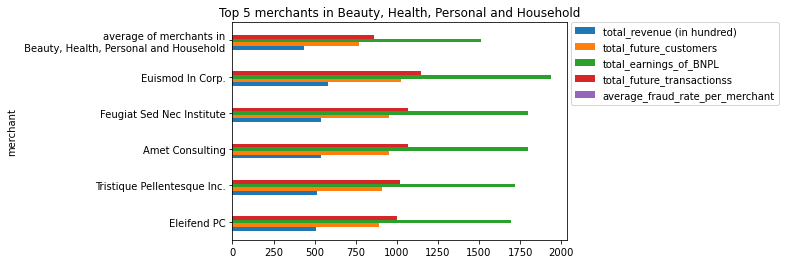

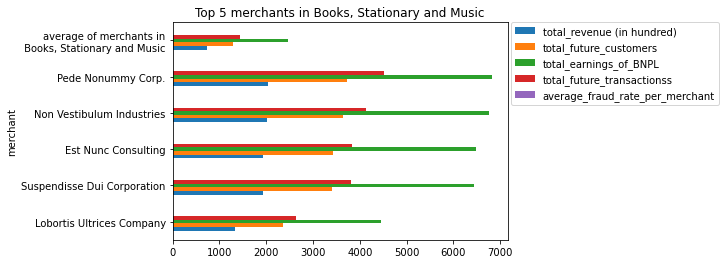

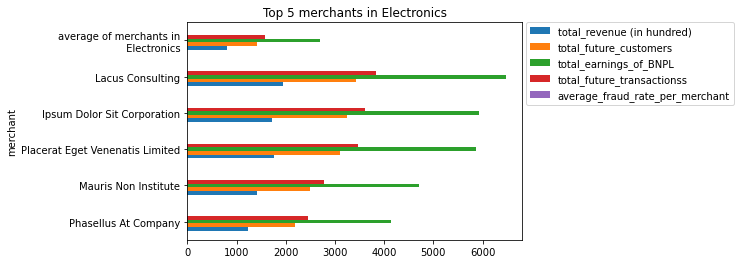

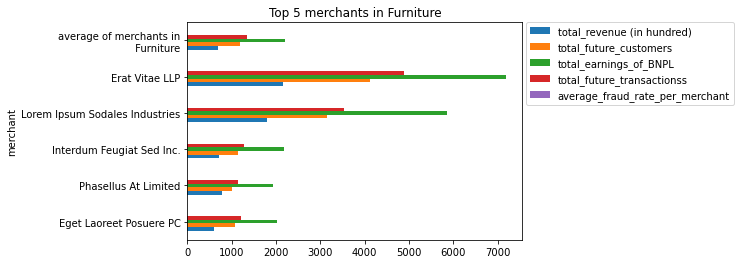

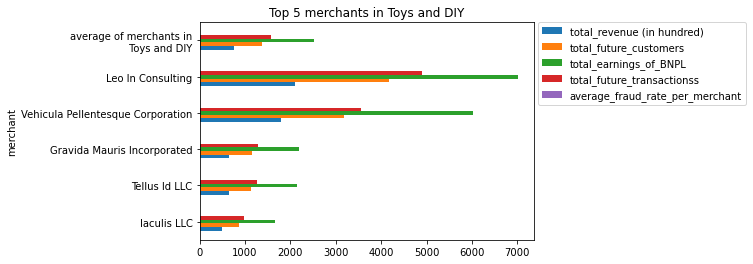

In [78]:
%run "../scripts/visualizations-2.py" '../scripts/paths.json'

22/10/09 14:32:51 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


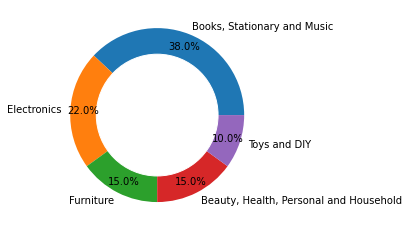

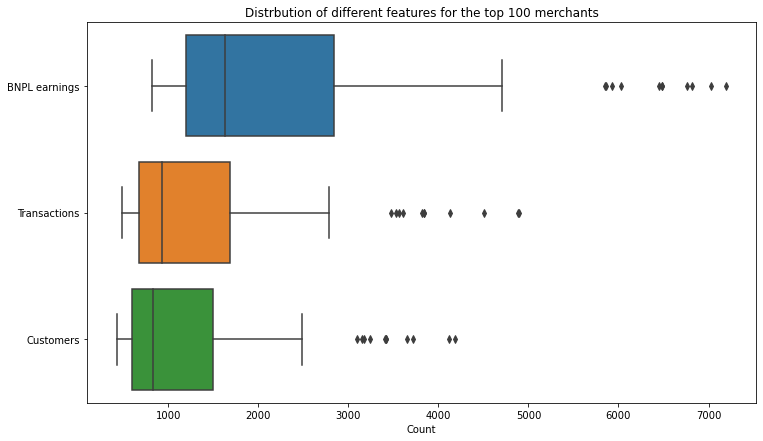

In [79]:
%run "../scripts/insights.py" '../scripts/paths.json'